### Methods for generating a 2D sketch of a scene/room

In [1]:
from utils_notebook import *
from sklearn.cluster import DBSCAN
import alphashape
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
CLOUD_POINT_PATH = "../output/rtabmap/point_cloud.ply"

#### First method : ransac for plane detection

First step is to load and voxelize the cloudpoint (too many points otherwise). We then for each point estimate its orientation, from its neighbors, that is its normal.

In [8]:
# 0.2 : rendu plus épuré mais on perd des murs; 0.15 rendu plus fidèle mais très brouillon
pts, cols = load_and_decimate_room_pc_voxels(CLOUD_POINT_PATH,0.03)
normals = normal_estimation(pts, k=16)

Estimating normals: 100%|██████████████████████████████████| 46073/46073 [00:02<00:00, 20353.86it/s]


Second step is to determine plans constituting the cloudpoints. In our case plans are vertical or horizontal and have a threshold of 0.3, which roughly means walls and ground can have a thickness of 30cm. Since the cloudpoint is not very precise, it is a good estimate. 
We are using ransac to associate the points to the planes, which finds iteratively the plane containing the most number of points and remove them from the next iteration. At the end, we have associated all points to a plane

In [9]:
shapes = ransac(pts, normals, min_pts=200,
                plane_search_function=search_one_plane_normals,
                plane_search_function_args=dict(
                    plane_threshold=0.3,
                    orient_threshold=0.9,
                    proba_of_success=0.999
                ))

100%|████████████████████████████████████████████████████████| 1588/1588 [00:00<00:00, 22879.62it/s]


Found one plane with 6206 inliers


100%|████████████████████████████████████████████████████████| 1374/1374 [00:00<00:00, 18419.00it/s]


Found one plane with 2879 inliers


100%|████████████████████████████████████████████████████████| 1275/1275 [00:00<00:00, 21323.48it/s]


Found one plane with 2132 inliers


100%|████████████████████████████████████████████████████████| 1201/1201 [00:00<00:00, 20907.89it/s]


Found one plane with 1997 inliers


100%|█████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 8462.59it/s]


Found one plane with 1833 inliers


100%|█████████████████████████████████████████████████████████| 1069/1069 [00:00<00:00, 8663.94it/s]


Found one plane with 1938 inliers


100%|████████████████████████████████████████████████████████| 1002/1002 [00:00<00:00, 26700.21it/s]


Found one plane with 1667 inliers


100%|██████████████████████████████████████████████████████████| 944/944 [00:00<00:00, 21019.50it/s]


Found one plane with 1379 inliers


100%|██████████████████████████████████████████████████████████| 897/897 [00:00<00:00, 20338.69it/s]


Found one plane with 1212 inliers


100%|██████████████████████████████████████████████████████████| 855/855 [00:00<00:00, 21172.47it/s]


Found one plane with 1113 inliers


100%|██████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 29913.49it/s]


Found one plane with 1037 inliers


100%|██████████████████████████████████████████████████████████| 780/780 [00:00<00:00, 24245.25it/s]


Found one plane with 803 inliers


100%|██████████████████████████████████████████████████████████| 753/753 [00:00<00:00, 43287.07it/s]


Found one plane with 742 inliers


100%|██████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 45250.63it/s]


Found one plane with 564 inliers


100%|██████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 30382.62it/s]


Found one plane with 543 inliers


100%|██████████████████████████████████████████████████████████| 689/689 [00:00<00:00, 46902.14it/s]


Found one plane with 601 inliers


100%|██████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 41528.38it/s]


Found one plane with 550 inliers


100%|██████████████████████████████████████████████████████████| 649/649 [00:00<00:00, 56135.10it/s]


Found one plane with 449 inliers


100%|██████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 58662.89it/s]


Found one plane with 404 inliers


100%|██████████████████████████████████████████████████████████| 620/620 [00:00<00:00, 46484.25it/s]


Found one plane with 324 inliers


100%|██████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 31275.06it/s]


Found one plane with 344 inliers


100%|██████████████████████████████████████████████████████████| 596/596 [00:00<00:00, 35730.90it/s]


Found one plane with 277 inliers


100%|██████████████████████████████████████████████████████████| 587/587 [00:00<00:00, 82321.00it/s]


Knowing the constitution of our scene, we can play on the number of planes returned here: we thus remove fioritures and unprecise points. 
To do so, we only keep the N planes containing the most number of points. In our case, we keep the 8 first ones.

shape_colors = []
shapes = shapes[:8]

for shape_pts in shapes:
    color = np.random.randint(0, 255, size=(1, 3))
    color = np.repeat(color, shape_pts.shape[0], axis=0)
    shape_colors.append(color)
shapes_cat = np.concatenate(shapes, axis=0)
shape_colors_cat = np.concatenate(shape_colors, axis=0)

point_cloud_visu(shapes_cat, shape_colors_cat)

Know comes the projection step. We only keep planes for which the furthest difference on the z axis between two points is superior to a threshold (here, 2m). This is done to filter planes and only keep the walls. We then project the points contained in the planes still there on a 2D plane.

In [20]:
seuil_hauteur = 0.5

shapes_flat = []
shape_colors = []

for shape_pts in shapes:
    z_range = shape_pts[:, 2].max() - shape_pts[:, 2].min()

    if z_range > seuil_hauteur:
        shape_proj = shape_pts.copy()
        shape_proj[:, 2] = 0

        shapes_flat.append(shape_proj)

        color = np.random.randint(0, 255, size=(1, 3))
        color = np.repeat(color, shape_proj.shape[0], axis=0)
        shape_colors.append(color)


if shapes_flat:
    shapes_cat = np.concatenate(shapes_flat, axis=0)
    shape_colors_cat = np.concatenate(shape_colors, axis=0)

    point_cloud_visu(shapes_cat, shape_colors_cat)
else:
    print("Aucune surface dépassant le seuil de hauteur.")

Lastly, and only if required, we can remove noise with DBScan, which is a clustering algorithm. Points with no cluster are to be removed as they are too far from others and thus not part of a wall.

In [21]:
clustering = DBSCAN(eps=0.3, min_samples=40).fit(shapes_cat)
labels = clustering.labels_
pts_2d_clean = shapes_cat[labels != -1]
point_cloud_visu(pts_2d_clean)

This method gives an estimate of the shape of a room, but we still have points, if we want to have a shape with lines we can use an alphashape method for example:

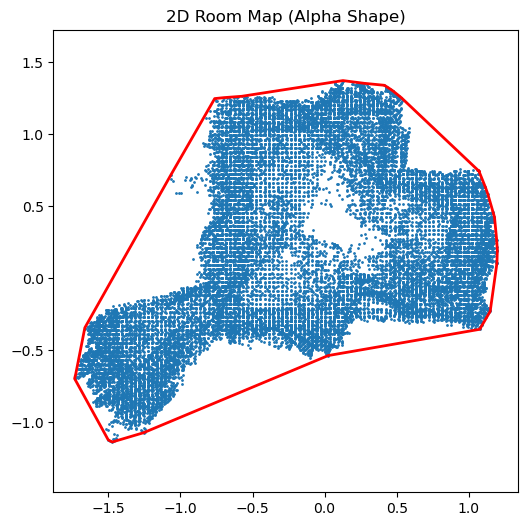

In [22]:
points_2d = pts_2d_clean[:, :2]

alpha = 0.3  # play with alpha to modulate on the number of edges of the polygon
shape = alphashape.alphashape(points_2d, alpha)

plt.figure(figsize=(6, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], s=1)
if isinstance(shape, Polygon):
    x, y = shape.exterior.xy
    plt.plot(x, y, 'r-', linewidth=2)
plt.title("2D Room Map (Alpha Shape)")
plt.axis("equal")
plt.show()

As the shape of the room is taken from the perimeter of the points, we can see it is very sensible to noise.

#### Second method : density and height maps

By playing with cell_size you get representations more or less precise, the lower the cell size, the more you see the points but the more precise it is

In [28]:
cell_size = 0.03
pts, _ = load_and_decimate_room_pc_voxels(CLOUD_POINT_PATH,cell_size)

In [29]:
x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
# Discrétisation
x_idx = ((x - x.min()) / cell_size).astype(int)
y_idx = ((y - y.min()) / cell_size).astype(int)

First is a simple density map : higher density in the 3D space are projected with a white color in 2D while lower density are darker

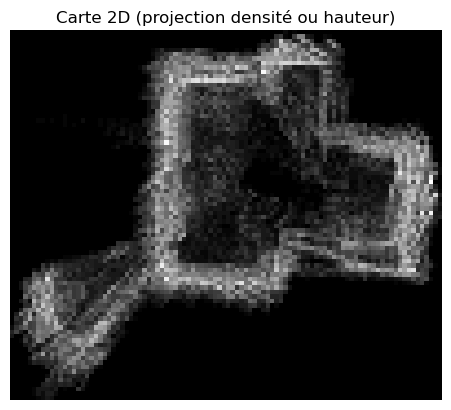

In [30]:
img_density = density_img(x_idx, y_idx)
plt.imshow(img_density, cmap='gray', origin='lower')
plt.title("Carte 2D (projection densité ou hauteur)")
plt.axis('off')
plt.show()

By playing with a density threshold we can get a representation with more or less noise:

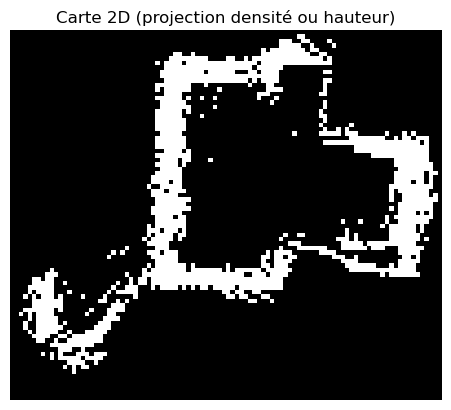

In [36]:
# only keep density higher than 25% of the point with max density
plt.imshow(img_density > 0.35, cmap='gray', origin='lower')
plt.title("Carte 2D (projection densité ou hauteur)")
plt.axis('off')
plt.show()

Secondly we can project the vertical height (z axis) on the 2D space.

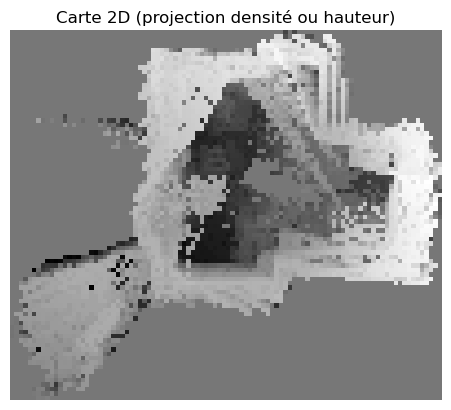

In [32]:
height_img = height_map(x_idx, y_idx, z)
plt.imshow(height_img, cmap='gray', origin='lower')
plt.title("Carte 2D (projection densité ou hauteur)")
plt.axis('off')
plt.show()

Same as before, if we put a threshold we can remove the noise (here the things which are not walls)

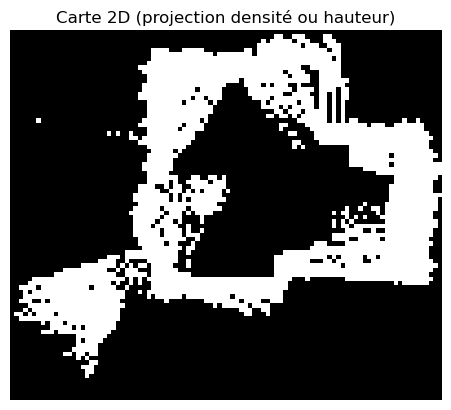

In [35]:
plt.imshow(height_img > 0.6, cmap='gray', origin='lower')
plt.title("Carte 2D (projection densité ou hauteur)")
plt.axis('off')
plt.show()